In [2]:
import numpy as np
import Data
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import constants
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.decomposition import PCA

Used functions

In [36]:
def visualize_errors(y_test,y_pred,modelname,n:int):
    plt.figure(figsize=(10,8))
    diff = y_test-y_pred
    sns.set_style("whitegrid")
    sns.despine()
    sns.histplot(diff)
    plt.xlabel("Błędy")
    plt.ylabel("Liczność")
    plt.title(f"Błędy predykcji {modelname}")
    div1_percentile = int(100*round(len(diff[diff<400]) / len(diff),2))
    div2_percentile = int(100*round(len(diff[diff<800]) / len(diff),2))
    plt.axvline(x=200, color='r', linestyle='--',label=f"Jedna dywizja (+-200lp) {div1_percentile}%")  # Line at x = 200
    plt.axvline(x=-200, color='r', linestyle='--') # Line at x = -200
    plt.axvline(x=400, color='g', linestyle='--',label=f"Dwie dywizje (+-400lp) {div2_percentile}%")  # Line at x = 400
    plt.axvline(x=-400, color='g', linestyle='--') # Line at x = -400
    plt.legend(fontsize=15)
    plt.grid(False)
    plt.savefig(f"RaportGraphs/errors_{modelname}_EXP{n}.png")
    
    plt.show()
    
def visualize_true_vs_pred(y_test,y_pred,modelname,n:int):
    plt.figure(figsize=(10,8))
    
    sns.set_style("whitegrid")
    sns.despine()
    sns.histplot(y_test, color='blue', label='Prawdziwe wartości',bins=40)
    sns.histplot(y_pred, color='red', label='Predykcje',bins=40, alpha=0.5)
    plt.xlabel("Poziom")
    plt.ylabel("Liczność")
    plt.title(f"Prawdziwe wartości a Predykcje {modelname}")
    plt.legend()
    plt.grid(False)
    plt.savefig(f"RaportGraphs/Pred_{modelname}_EXP{n}.png")
    
    plt.show()
    
    

In [4]:
df_per_rank_list= Data.all_ranks_list_df("MatchData")




# Kills_t and deaths_t are essencially the same feature, so we'll erase one of them. #

Merge all dataframes into one, and drop deaths_t column.

In [5]:
df = Data.make_big_df(df_per_rank_list)


In [6]:
df.head()

,id,lvl,literal level,time,solokills_t,kills_t,kp,deaths_t,assists_t,csscore_t,teamgold_t,vision_score_t,wards_placed_t,gold_graph_diffs_t
0,EUN1_3579653756,200,IRON II,1455,0.017182,0.042612,0.401429,0.043299,0.038488,0.709278,64.401375,0.495233,0.042612,15.551890
1,EUN1_3579633568,200,IRON II,2032,0.009843,0.036417,0.477901,0.036417,0.051181,0.654035,61.689469,0.757127,0.059547,16.534941
2,EUN1_3578675808,200,IRON II,1294,0.012365,0.024730,0.327536,0.024730,0.015456,0.685471,53.860896,0.502003,0.039413,9.488408
3,EUN1_3578667593,200,IRON II,1459,0.005483,0.031528,0.418925,0.031528,0.037012,0.682659,59.134339,0.533977,0.045922,14.766964
4,EUN1_3578250711,100,IRON III,2812,0.009246,0.037696,0.458143,0.037696,0.048720,0.666785,64.629801,0.799291,0.068990,16.120555


For regression, we won't need id and literal level column.

In [7]:
columns_to_drop = ['id','literal level','deaths_t']
df = df.drop(columns=columns_to_drop)

In [8]:
df.head()

,lvl,time,solokills_t,kills_t,kp,assists_t,csscore_t,teamgold_t,vision_score_t,wards_placed_t,gold_graph_diffs_t
0,200,1455,0.017182,0.042612,0.401429,0.038488,0.709278,64.401375,0.495233,0.042612,15.551890
1,200,2032,0.009843,0.036417,0.477901,0.051181,0.654035,61.689469,0.757127,0.059547,16.534941
2,200,1294,0.012365,0.024730,0.327536,0.015456,0.685471,53.860896,0.502003,0.039413,9.488408
3,200,1459,0.005483,0.031528,0.418925,0.037012,0.682659,59.134339,0.533977,0.045922,14.766964
4,100,2812,0.009246,0.037696,0.458143,0.048720,0.666785,64.629801,0.799291,0.068990,16.120555


Determining target and features

In [9]:
y = df['lvl']
X = df.drop(columns=['lvl'])

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


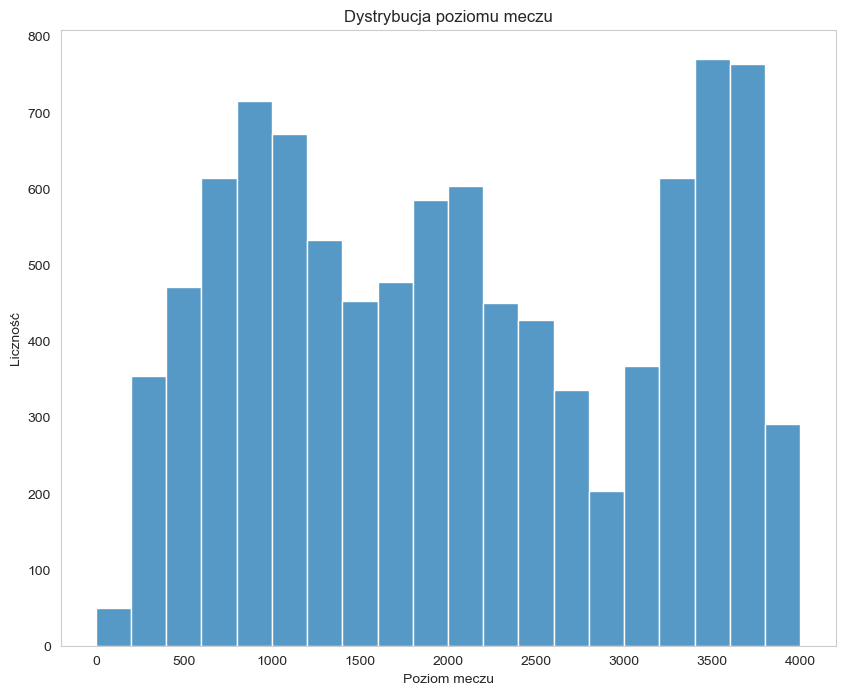

In [10]:
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
sns.despine()
plt.xlabel("Poziom meczu")
plt.ylabel("Liczność")
plt.title(f"Dystrybucja poziomu meczu")
plt.grid(False)
sns.histplot(y)
plt.savefig("RaportGraphs/HistPoziom.png")


Train test split and normalize

In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.33,
                                                        random_state=42)

Used regressors

In [12]:
regressors = {
        "Linear Regression": LinearRegression(),
        "Gradient Boost": GradientBoostingRegressor(),
        "Random Forest": RandomForestRegressor(),
        "Support Vector Machine": SVR(),
    }

regressors_params ={
    "Gradient Boost": {
        'n_estimators': [50, 100, 150,200,250],
        'learning_rate': [0.01,0.095,0.1,0.075,0.080,0.085,0.090,0.105,0.110,0.115, 0.2],
        'max_depth': [3, 5, 7]
    },
    "Random Forest": {
        'n_estimators': [10,20,30,40,50],
        'max_depth': [2,4,5, 10,],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    "Support Vector Machine": {
        'kernel': ['rbf', 'linear'],  
        'C': [0.1, 1, 70,80,90, 100,],        
        'gamma': [0.01, 0.1, 1, 10],   
        'epsilon': [0.01, 0.1, 1]      
    },
    
}

# Start off with  LinearReggresion #

In [16]:
lr_model = regressors['Linear Regression']
lr_model.fit(X_train,y_train)
lr_pred = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test,lr_pred))
print(f'Linear Model Params: {np.round(lr_model.coef_,5)}, {np.round(lr_model.intercept_,5)}')
print(f'Root Square Mean Error: {rmse_lr}')

Linear Model Params: [-331.77867   88.41569 -290.30211  -41.40792  519.75335  592.44395
   99.64856  299.0952   -15.48315   12.03253], 2021.66653
Root Square Mean Error: 574.879800277412


In [13]:
#visualize_errors(y_test,lr_pred,'LR')

# Gradient Boost Regressor #

In [14]:
gb_regressor = regressors["Gradient Boost"]
def grid_gb(gb):
    # Define the hyperparameters grid
    param_grid = {
        'n_estimators': [50, 100, 150,200,250],
        'learning_rate': [0.01,0.095,0.1,0.075,0.080,0.085,0.090,0.105,0.110,0.115, 0.2],
        'max_depth': [3, 5, 7]
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=16, scoring='neg_mean_squared_error')
    
    # Perform grid search
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters found
    best_params = grid_search.best_params_
    print("Best Parameters:", grid_search.best_params_)
    
    # Evaluate the model on the test set
    gb_best = grid_search.best_estimator_
    return gb_best,best_params

gb_best, best_params = grid_gb(gb_regressor)

Best Parameters: {'learning_rate': 0.085, 'max_depth': 5, 'n_estimators': 100}


In [15]:
gb_best.fit(X_train,y_train)
gb_pred = gb_best.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test,gb_pred))
print(best_params)
print(f'Root Square Mean Error: {rmse_rf}')

{'learning_rate': 0.085, 'max_depth': 5, 'n_estimators': 100}
Root Square Mean Error: 518.2328813157603


In [16]:
#visualize_errors(y_test,gb_pred,"GB")

# Random Forest Regressor #

In [17]:
rf_regressor = regressors['Random Forrest']
def grid_rf(rf):
    param_grid = {
        'n_estimators': [10,20,30,40,50],
        'max_depth': [2,4,5, 10,],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5,n_jobs=16,verbose=3)
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters
    best_params = grid_search.best_params_
    
    print("Best parameters:", best_params)
    rf_regressor_best = grid_search.best_estimator_
    return rf_regressor_best,best_params

rf_regressor_best, best_params = grid_rf(rf_regressor)

KeyError: 'Random Forrest'

In [ ]:

rf_regressor_best.fit(X_train,y_train)
rf_pred = rf_regressor_best.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test,rf_pred))
print(best_params)
print(f'Root Square Mean Error: {rmse_rf}')

In [ ]:
#visualize_errors(y_test,rf_pred,"RF")

# SVR #

In [ ]:
svr = regressors["Support Vector Machine"]
def grid_svr(svr):
    # Parameter grid for grid search
    param_grid = {
        'kernel': ['rbf', 'linear'],  # Kernel type
        'C': [0.1, 1, 70,80,90, 100,],        # Regularization parameter
        'gamma': [0.01, 0.1, 1, 10],   # Kernel coefficient (for rbf kernel)
        'epsilon': [0.01, 0.1, 1]      # Epsilon in the epsilon-SVR model
    }
    
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5,n_jobs=16,verbose=3)
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)
    
    svr_best = grid_search.best_estimator_
    return svr_best,best_params

svr_best,best_params = grid_svr(svr)

In [ ]:
svr_best.fit(X_train,y_train)
svr_pred = svr_best.predict(X_test)
rmse_svr = np.sqrt(mean_squared_error(y_test,svr_pred))
print(best_params)
print(f'Root Square Mean Error: {rmse_svr}')

In [ ]:
#visualize_errors(y_test,svr_pred,"SVR")

In [13]:
def perform_grid(model_tuple,X_train,y_train):
    name,model = model_tuple
    grid_search = GridSearchCV(estimator=model, param_grid=regressors_params[name], cv=5,n_jobs=16,verbose=3)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f" {model.__class__.__name__} Best parameters: { best_params} ")
    
    svr_best = grid_search.best_estimator_
    return svr_best,best_params

In [14]:
def perform_model(model_tuple,X_train,X_test,y_train,y_test):
    name, model =model_tuple
    if name in regressors_params:
        model, params = perform_grid(model_tuple,X_train,y_train)
    
        
        
    model.fit(X_train,y_train)
    model_pred = model.predict(X_test)
    rmse_model = np.sqrt(mean_squared_error(y_test,model_pred))
    if not name in regressors_params:
        print(f'Linear Model Params: {np.round(model.coef_,5)}, {np.round(model.intercept_,5)}')
    return model_pred,rmse_model
    

In [15]:
def perform_experiment(models_dict,data_tuple,n):
    X_train,X_test,y_train,y_test = data_tuple
    for name,model in models_dict.items():
        model_pred,rmse_model = perform_model((name,model),X_train,X_test,y_train,y_test)
        print(f"{name} RMSE: {rmse_model}")
        visualize_errors(y_test,model_pred,name,n)
        visualize_true_vs_pred(y_test,model_pred,name,n)
        

# Eksperyment 1 #

Wszystkie cechy

In [32]:

df = Data.make_big_df(df_per_rank_list)
columns_to_drop = ['id','literal level','deaths_t']
df = df.drop(columns=columns_to_drop)
y = df['lvl']
X = df.drop(columns=['lvl'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.33,
                                                        random_state=42)

Linear Model Params: [-331.77867   88.41569 -290.30211  -41.40792  519.75335  592.44395
   99.64856  299.0952   -15.48315   12.03253], 2021.66653
Linear Regression RMSE: 574.879800277412


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


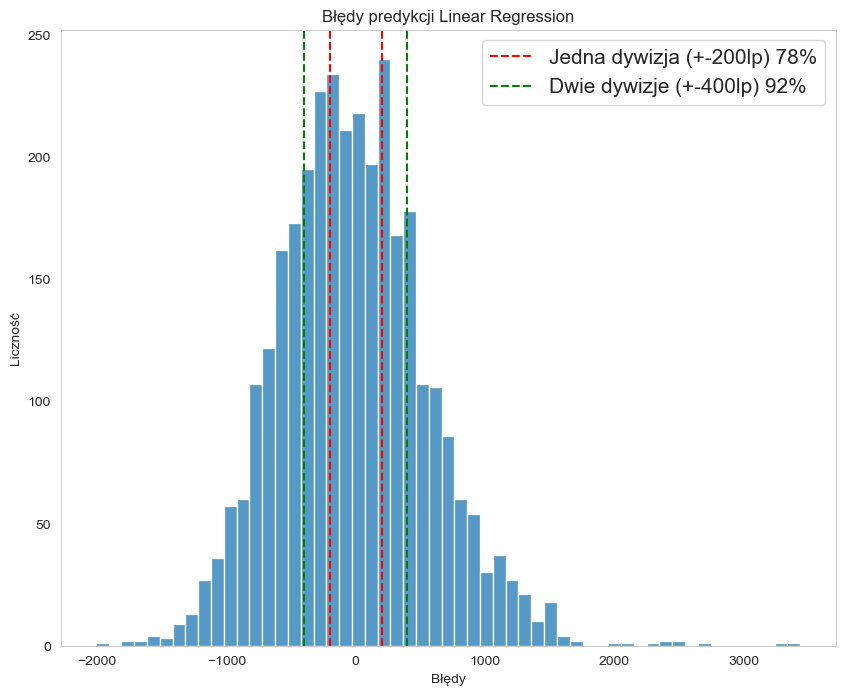

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


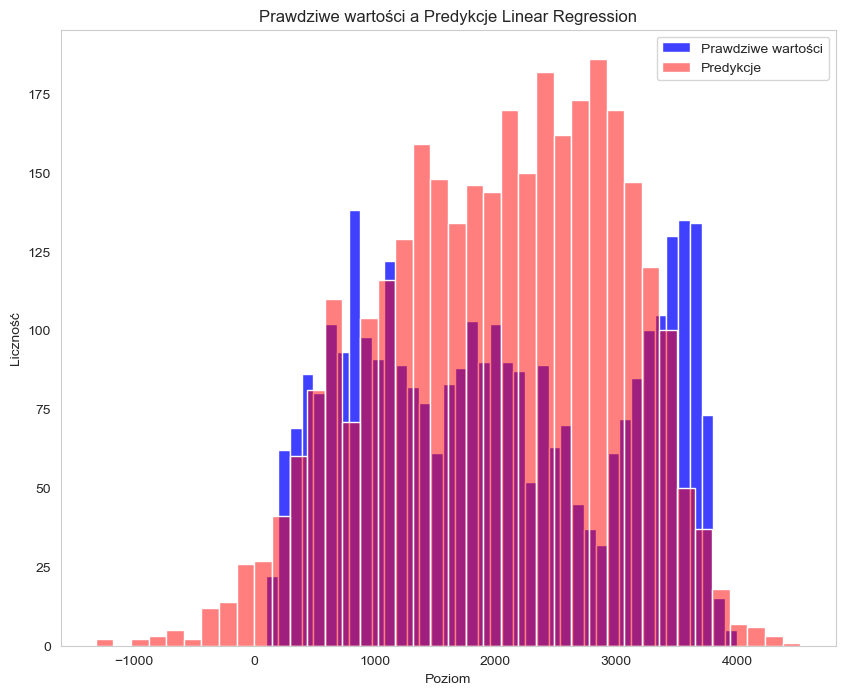

Fitting 5 folds for each of 165 candidates, totalling 825 fits
 GradientBoostingRegressor Best parameters: {'learning_rate': 0.085, 'max_depth': 5, 'n_estimators': 100} 
Gradient Boost RMSE: 517.7727527321714


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


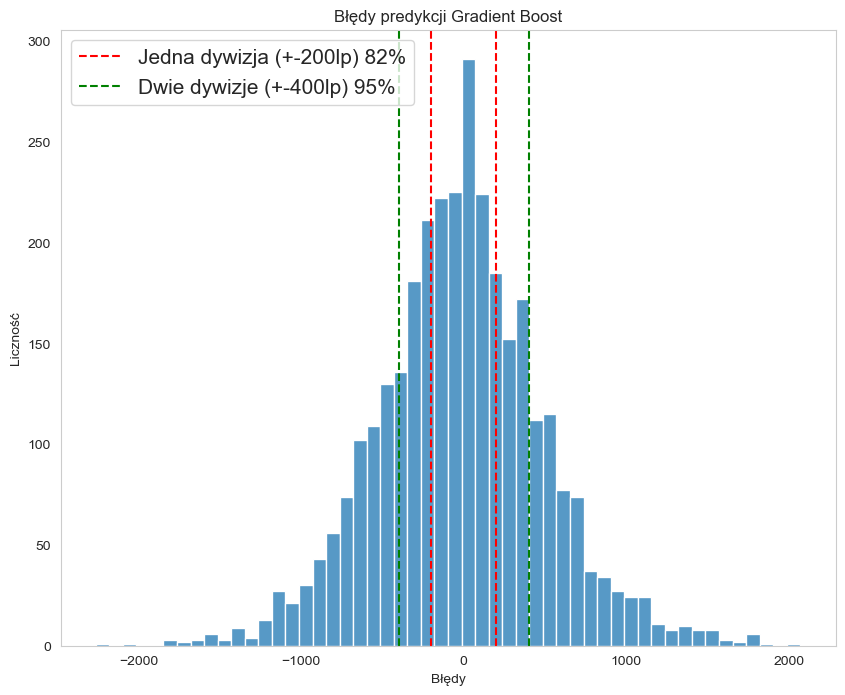

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


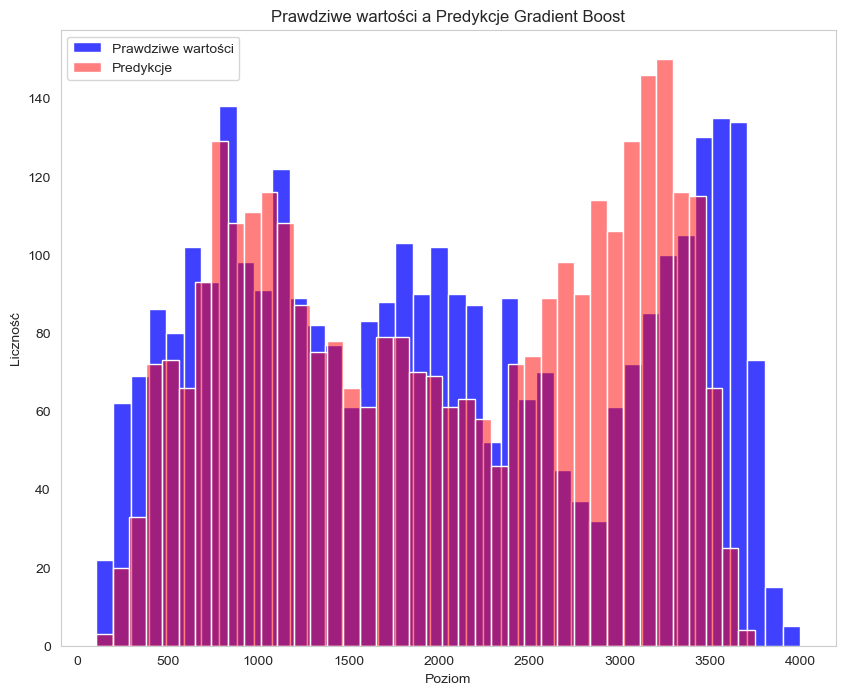

Fitting 5 folds for each of 180 candidates, totalling 900 fits
 RandomForestRegressor Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50} 
Random Forest RMSE: 525.6118910021096


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


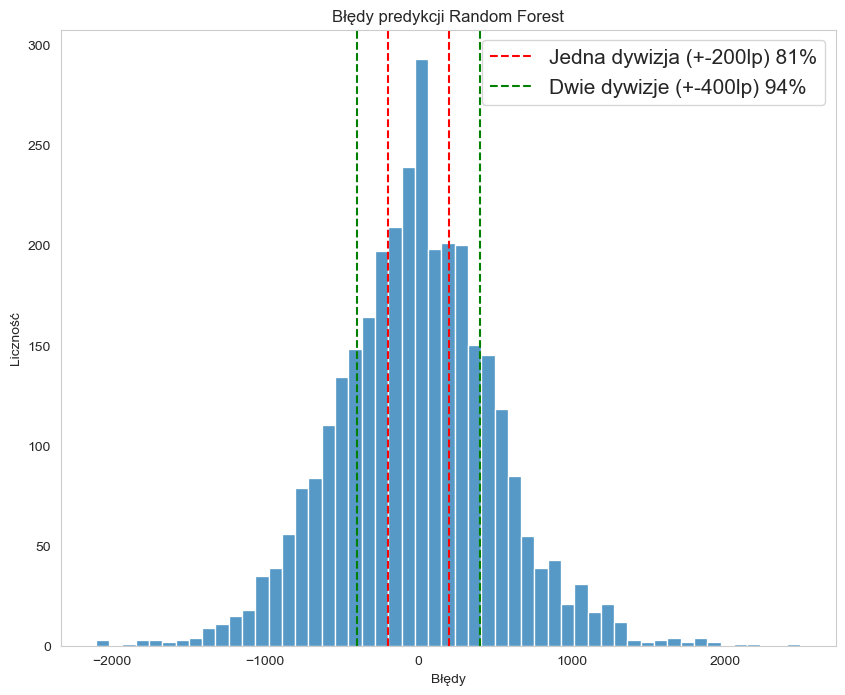

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


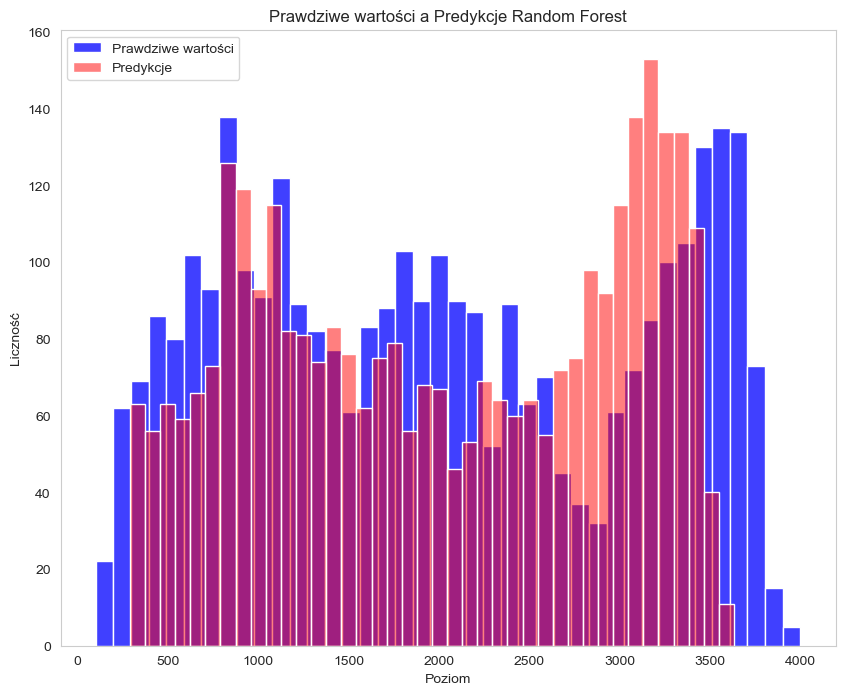

Fitting 5 folds for each of 144 candidates, totalling 720 fits
 SVR Best parameters: {'C': 100, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'rbf'} 
Support Vector Machine RMSE: 526.447219578519


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


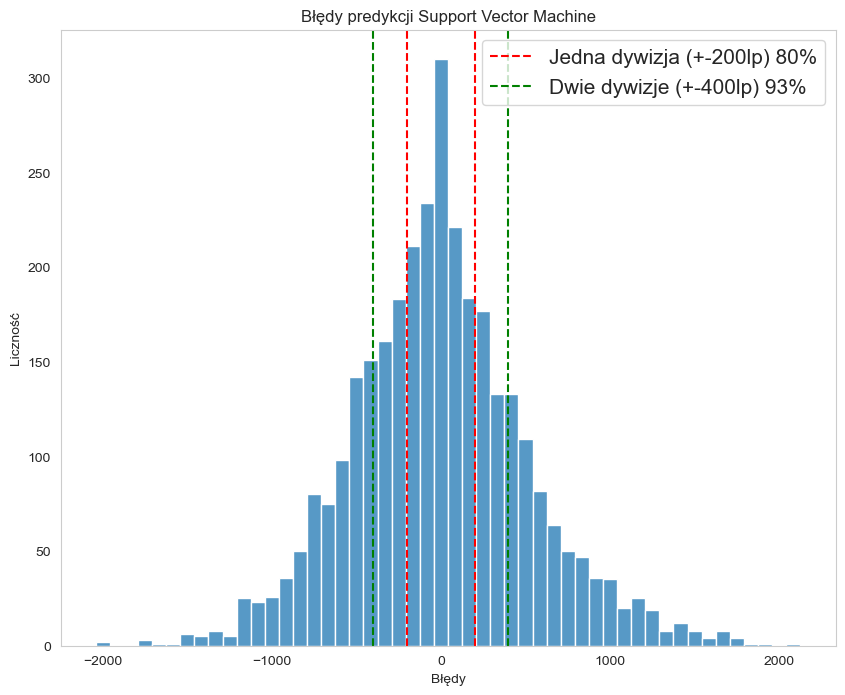

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


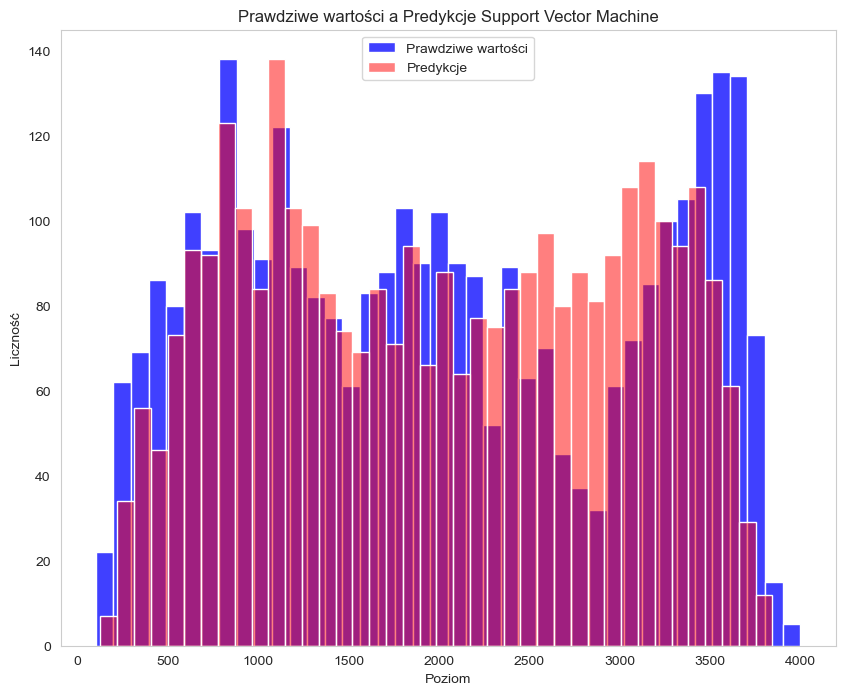

In [37]:


perform_experiment(regressors,(X_train,X_test,y_train,y_test),1)

# Eksperyment 2 #

Wybrano mocno cechy mocno skorelowane z poziomem. Brane cechy pod uwagę: 'vision_score_t','csscore_t','kp','teamgold_t'

In [38]:


corr_df = df[['vision_score_t','csscore_t','kp','teamgold_t']]
y = df['lvl']
X = corr_df
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.33,
                                                        random_state=42)

Linear Model Params: [151.62496 698.83197 213.72177 136.1411 ], 2021.12878
Linear Regression RMSE: 656.7133450470249


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


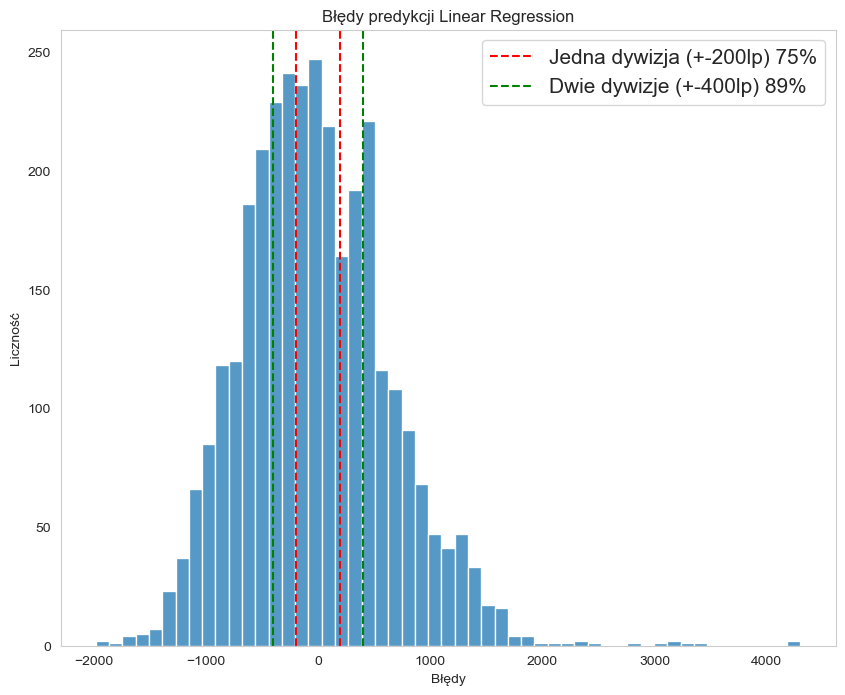

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


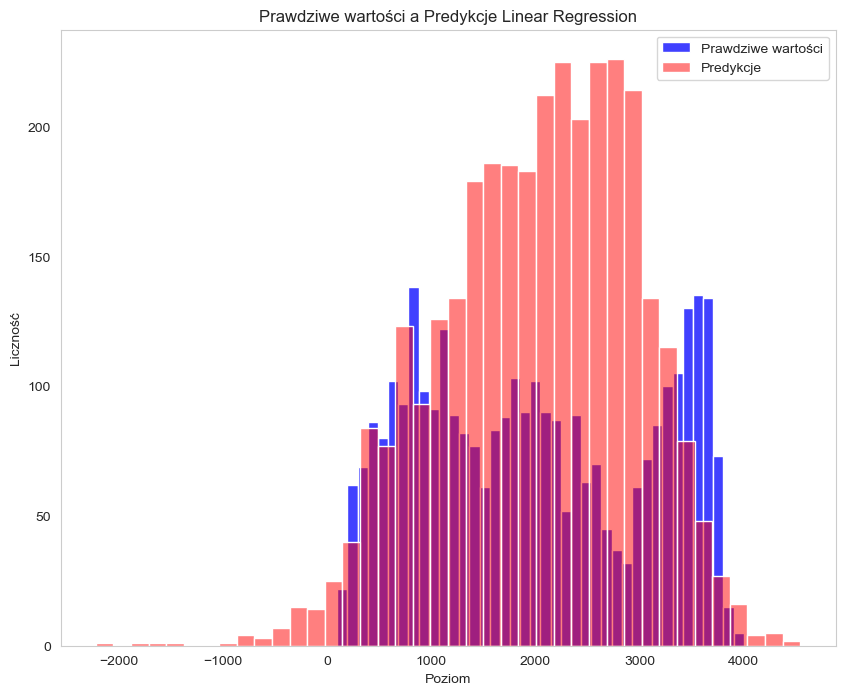

Fitting 5 folds for each of 165 candidates, totalling 825 fits
 GradientBoostingRegressor Best parameters: {'learning_rate': 0.095, 'max_depth': 5, 'n_estimators': 50} 
Gradient Boost RMSE: 589.7006212424361


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


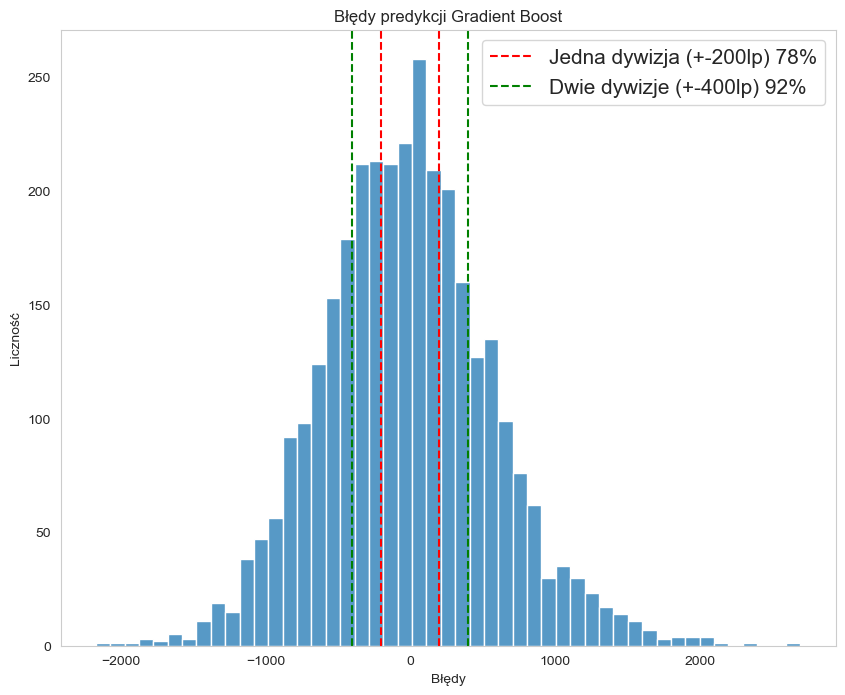

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


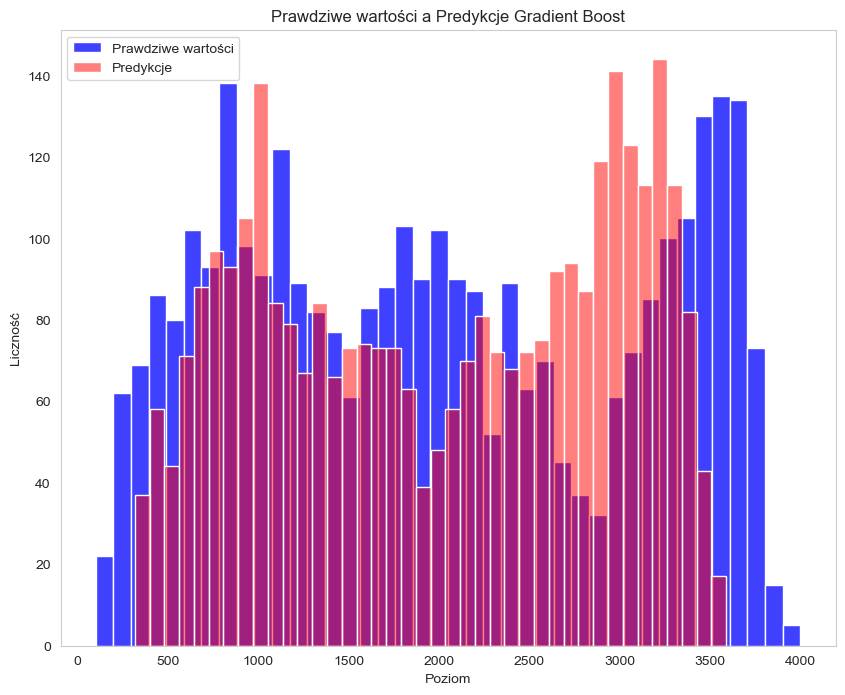

Fitting 5 folds for each of 180 candidates, totalling 900 fits
 RandomForestRegressor Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50} 
Random Forest RMSE: 589.0773049042849


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


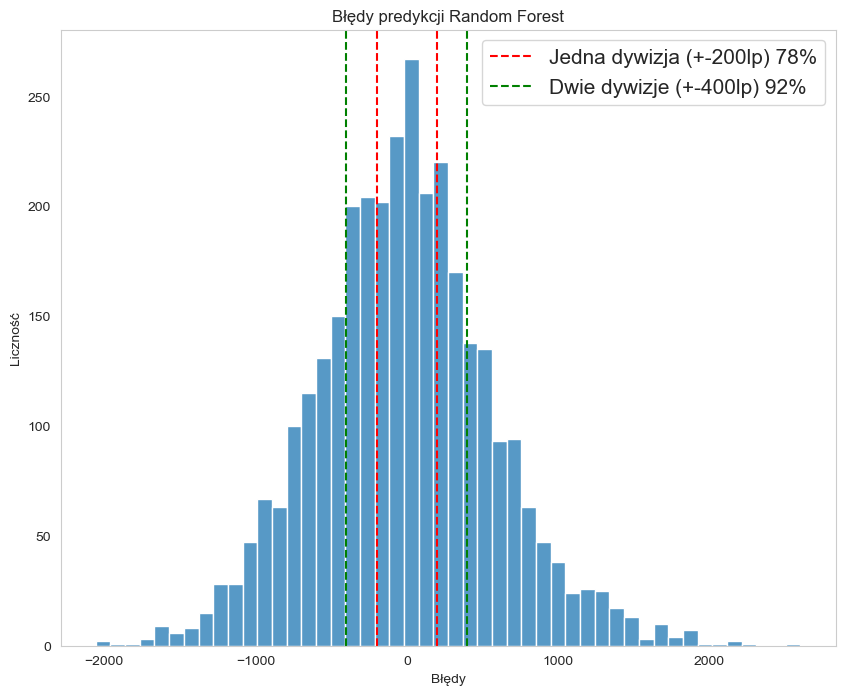

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


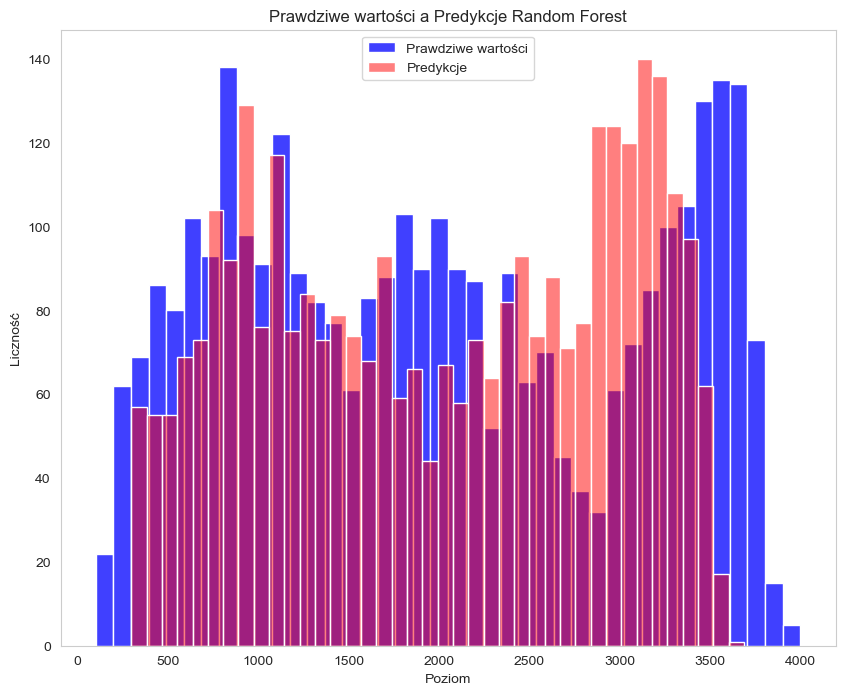

Fitting 5 folds for each of 144 candidates, totalling 720 fits
 SVR Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} 
Support Vector Machine RMSE: 592.7251038457811


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


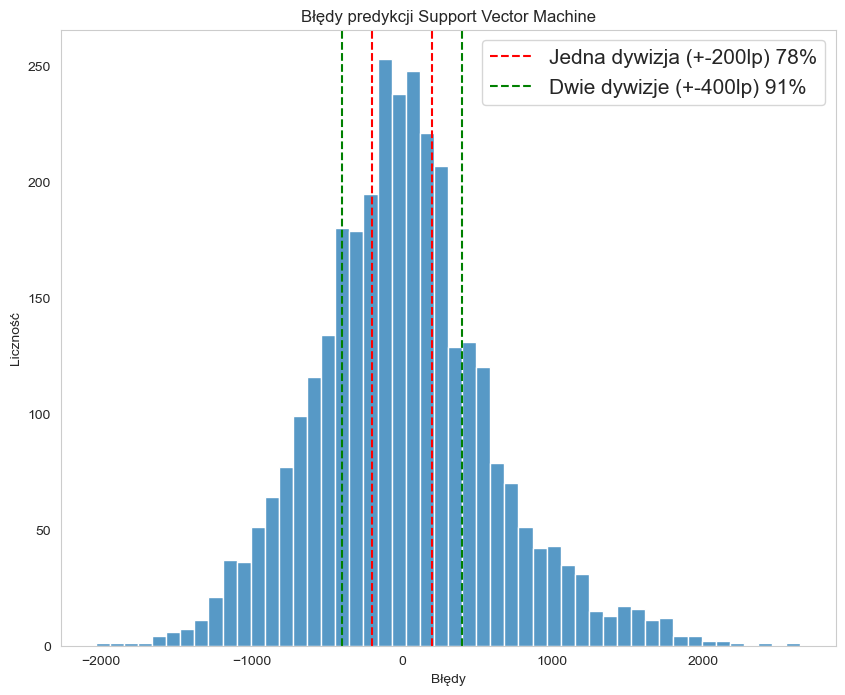

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


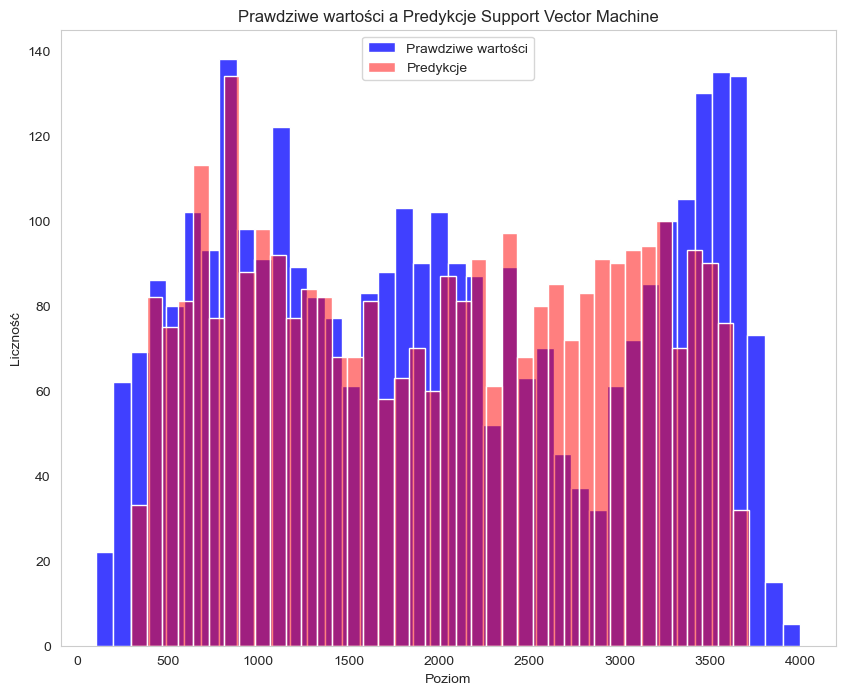

In [39]:
perform_experiment(regressors,(X_train, X_test, y_train, y_test),2)

# Eksperyment 3 #

Wybrano  cechy mocno skorelowane z poziomem. Brane cechy pod uwagę: 'vision_score_t','csscore_t','kp','teamgold_t', 'wards_placed_t','solokills_t'

In [40]:
corr_df = df[['vision_score_t','csscore_t','kp','teamgold_t','wards_placed_t','solokills_t']]
y = df['lvl']
X = corr_df
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.33,
                                                        random_state=42)

Linear Model Params: [134.79818 700.61733 218.13757 135.09463  19.92032   4.53345], 2021.10075
Linear Regression RMSE: 657.0064217961499


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


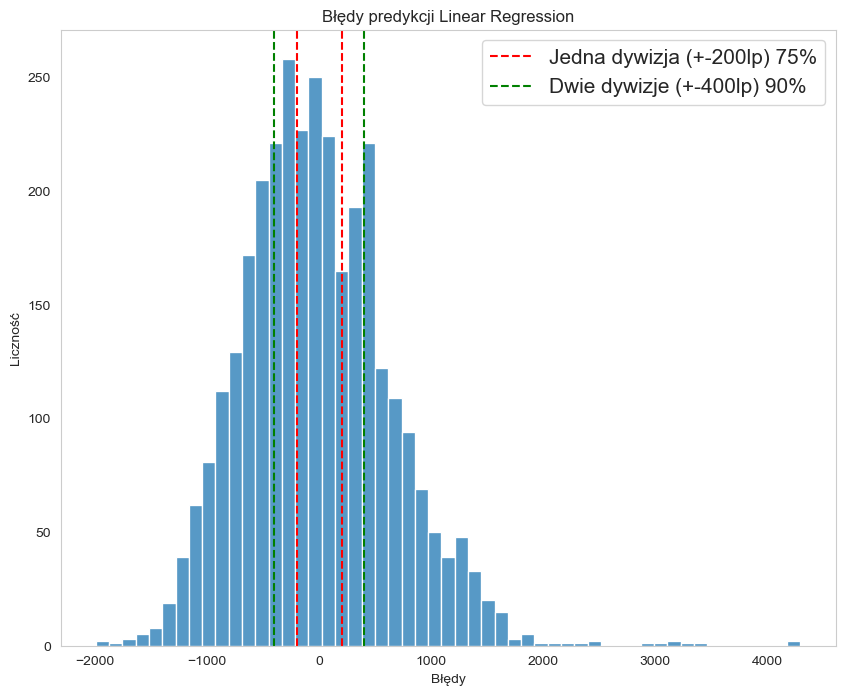

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


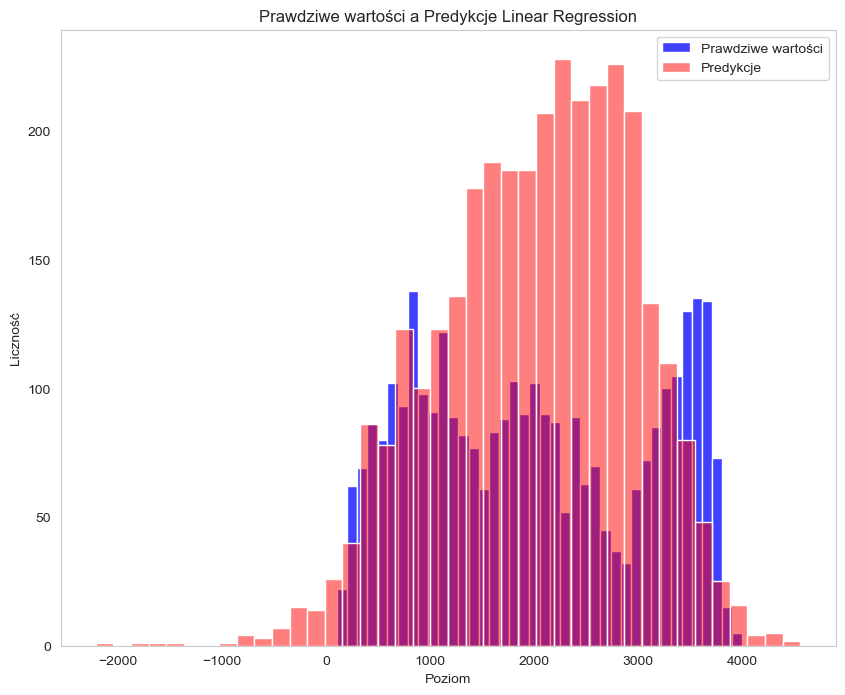

Fitting 5 folds for each of 165 candidates, totalling 825 fits
 GradientBoostingRegressor Best parameters: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 150} 
Gradient Boost RMSE: 587.8728790804224


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


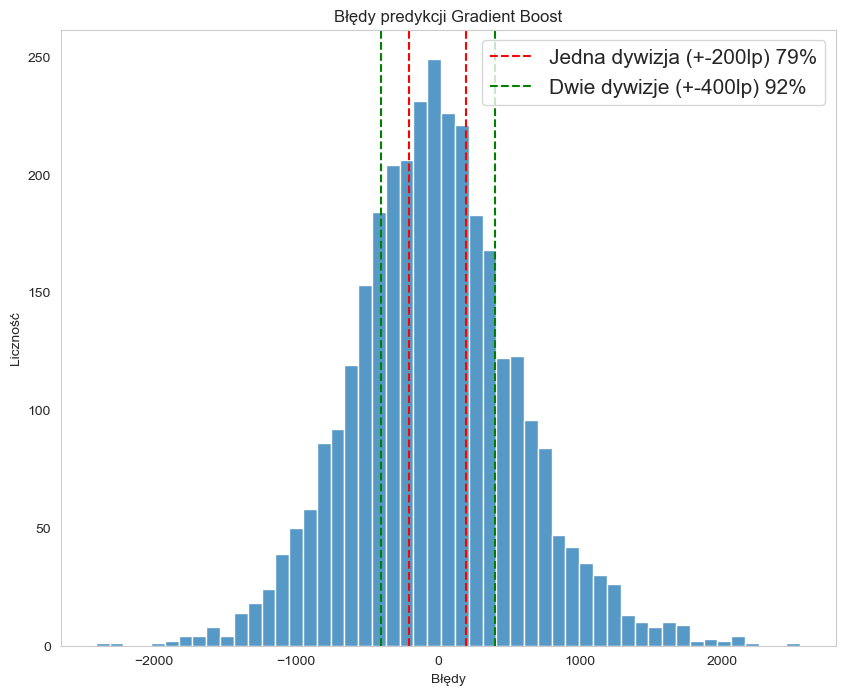

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


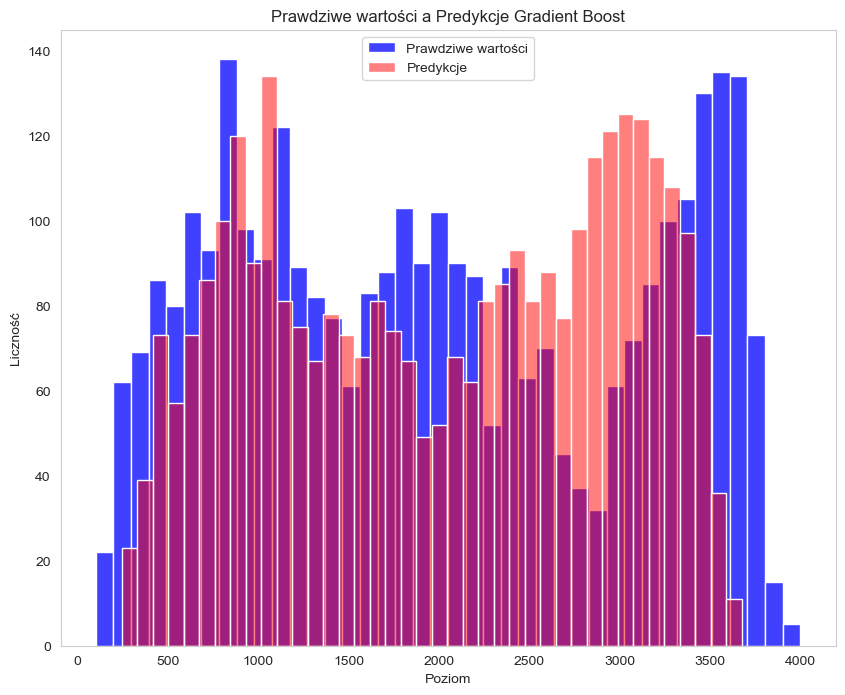

Fitting 5 folds for each of 180 candidates, totalling 900 fits
 RandomForestRegressor Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50} 
Random Forest RMSE: 587.9418747782408


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


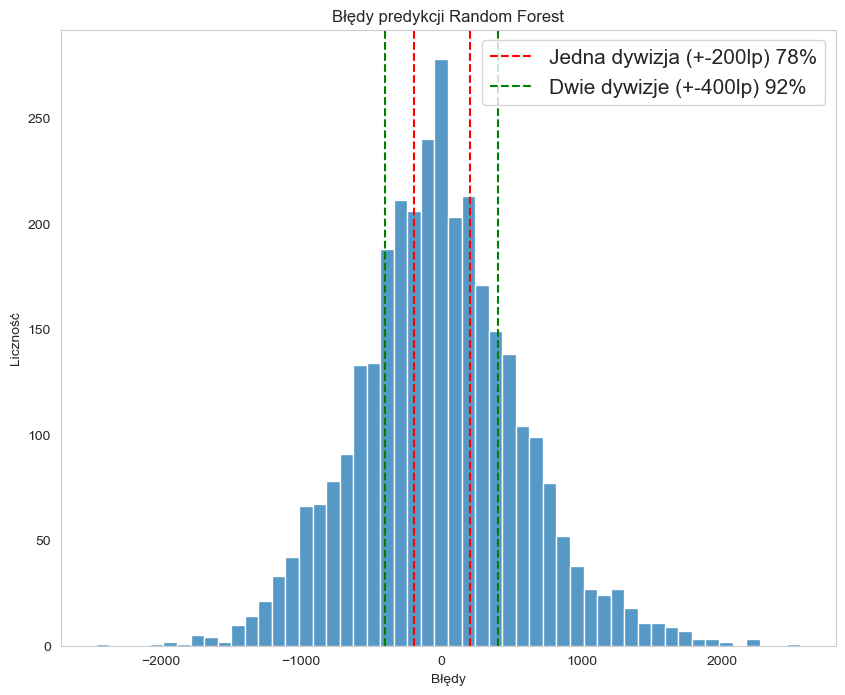

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


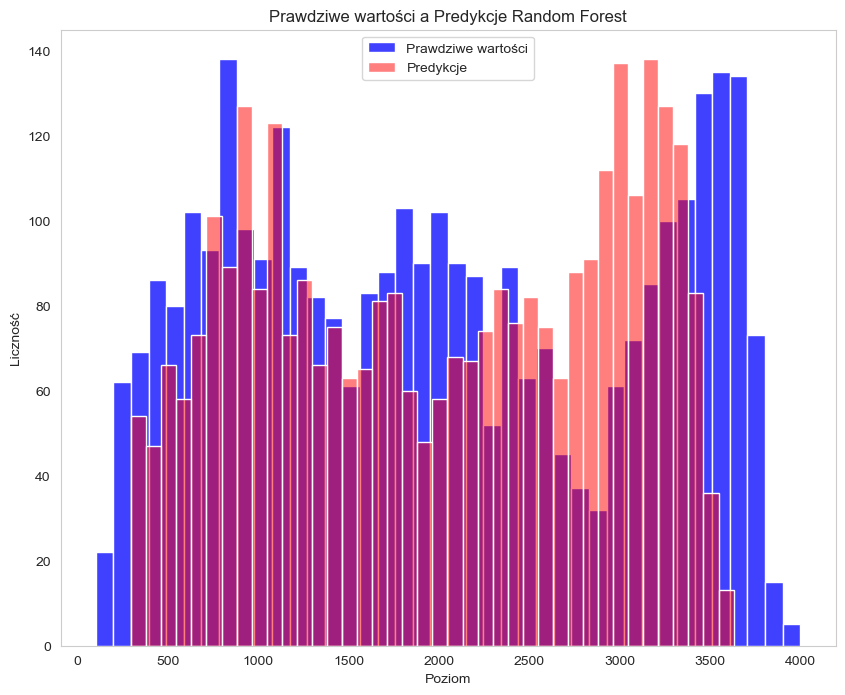

Fitting 5 folds for each of 144 candidates, totalling 720 fits
 SVR Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} 
Support Vector Machine RMSE: 591.8704445634694


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


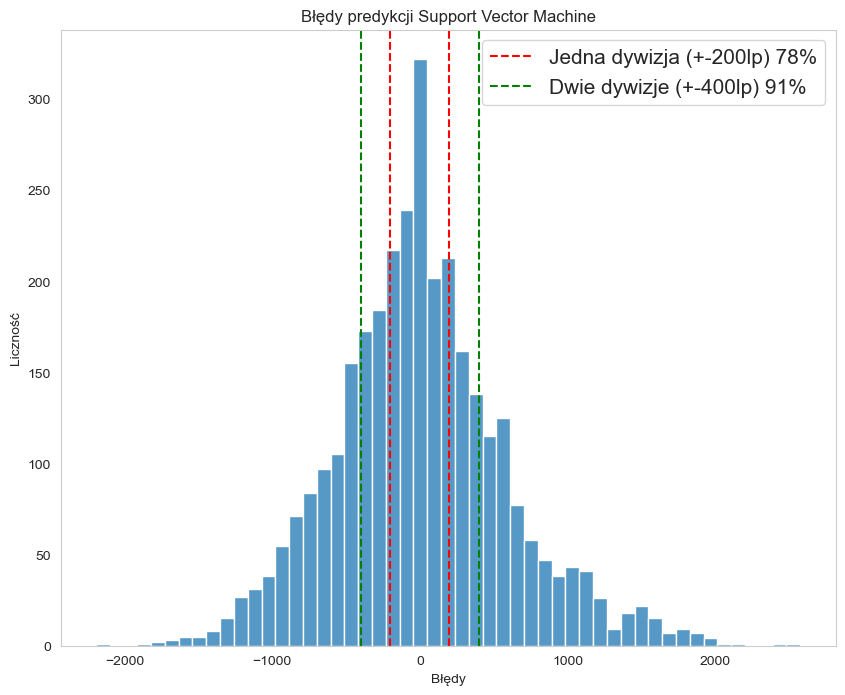

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


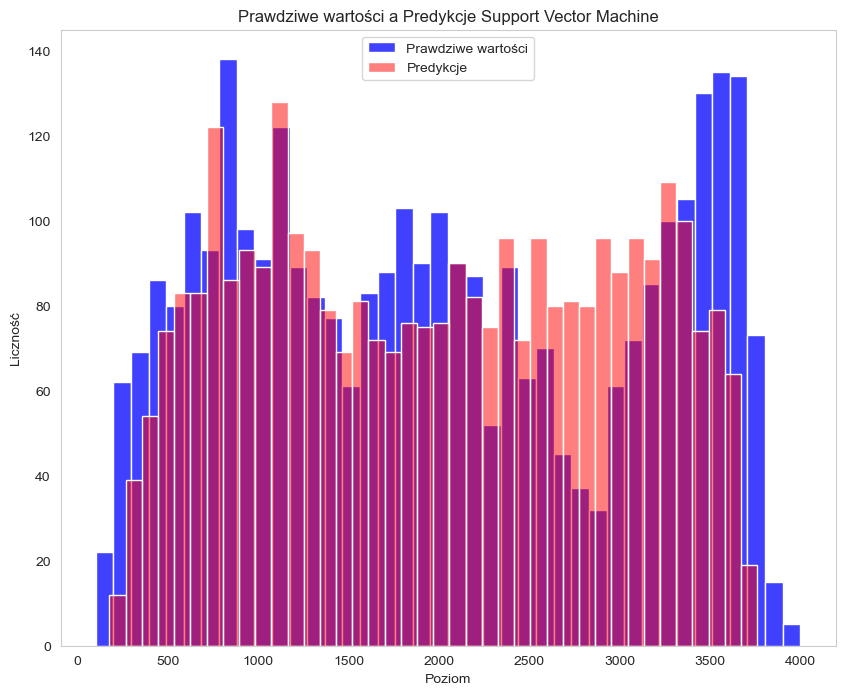

In [41]:
perform_experiment(regressors,(X_train, X_test, y_train, y_test),3)

# Experyment 4 #

Użycie PCA, 5 argumentów

In [42]:
df = Data.make_big_df(df_per_rank_list)
columns_to_drop = ['id','literal level','deaths_t']
df = df.drop(columns=columns_to_drop)
y = df['lvl']
X = df.drop(columns=['lvl'])
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)
n=5

pca = PCA(n_components=n) 
X_pca = pca.fit_transform(x_scaled)

pca_df = pd.DataFrame(X_pca, columns=[f'Principal Component {i}' for i in range(1,n+1)])

X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.33,
                                                        random_state=42)
print("\nGłówne składowe:")
print(pca_df.head())


Główne składowe:
   Principal Component 1  Principal Component 2  Principal Component 3  \
0              -2.897573              -2.849318              -0.154551   
1              -0.322005              -1.069650              -1.951769   
2              -6.159705               0.686978              -1.134607   
3              -2.816518              -0.041592              -1.989053   
4               0.670002              -1.187630              -1.878285   

   Principal Component 4  Principal Component 5  
0              -0.652254               0.448962  
1               0.014569               1.509575  
2               0.735648              -0.008906  
3              -1.184468               0.952149  
4               1.527643               1.874264  


Linear Model Params: [ 284.42272  280.1109   429.10637 -341.35779 -203.35292], 2020.85741
Linear Regression RMSE: 591.9352986562808


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


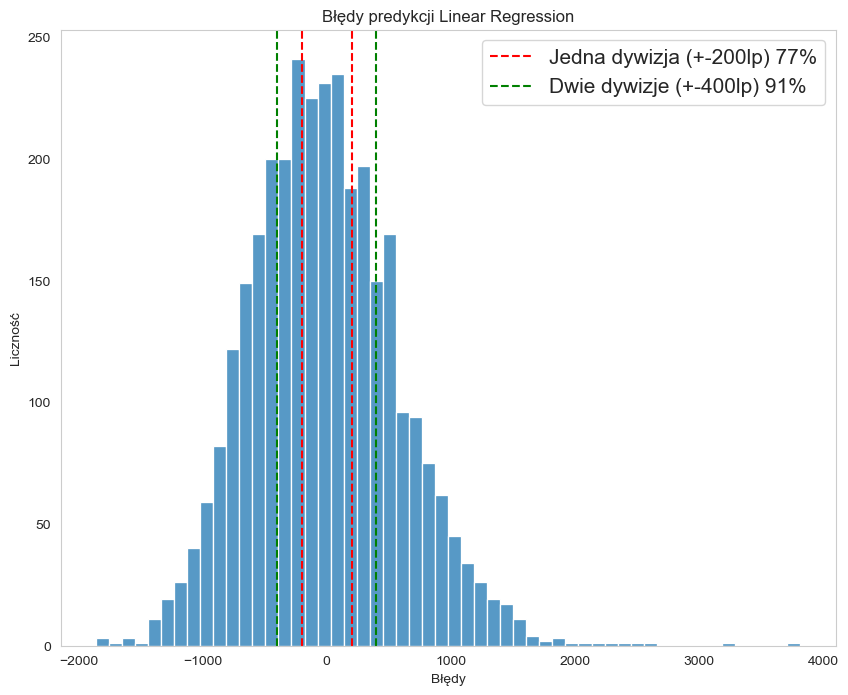

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


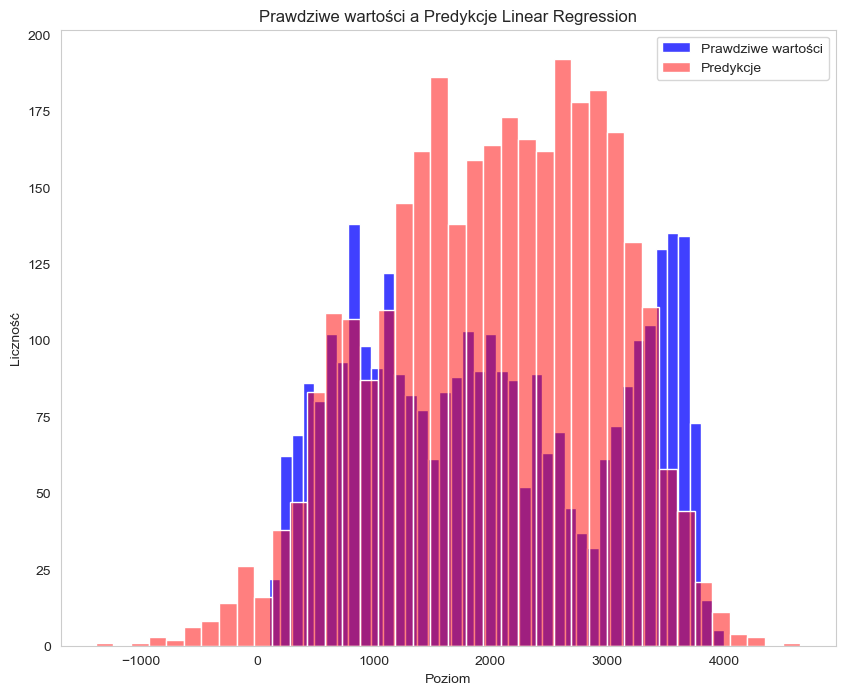

Fitting 5 folds for each of 165 candidates, totalling 825 fits
 GradientBoostingRegressor Best parameters: {'learning_rate': 0.075, 'max_depth': 5, 'n_estimators': 100} 
Gradient Boost RMSE: 551.0594944253837


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


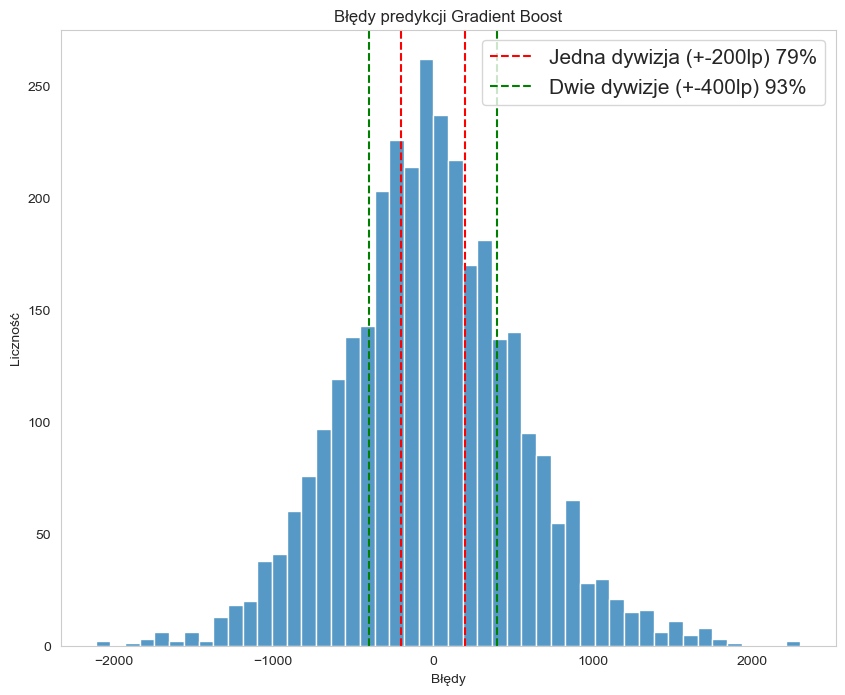

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


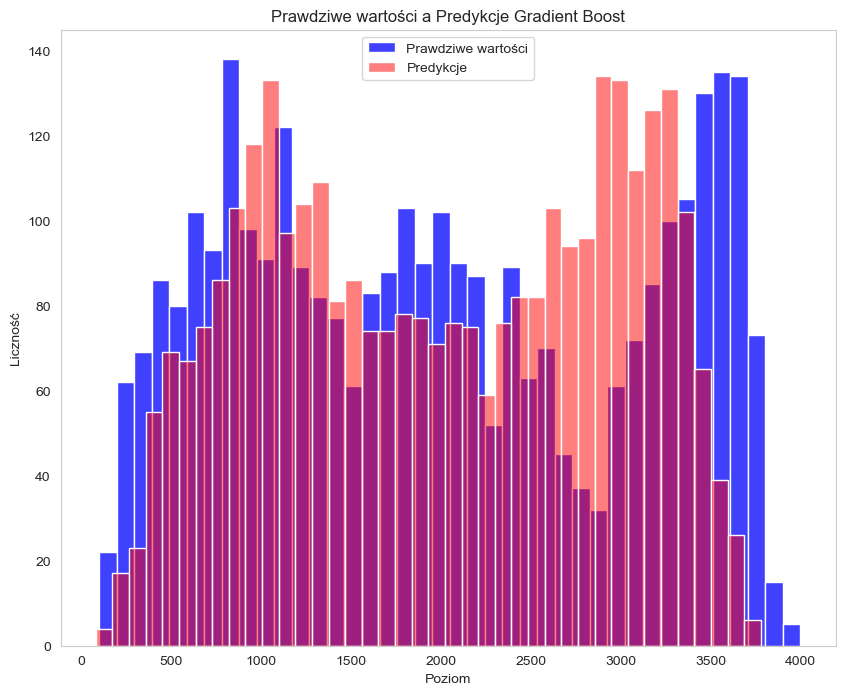

Fitting 5 folds for each of 180 candidates, totalling 900 fits
 RandomForestRegressor Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 40} 
Random Forest RMSE: 564.4694424130233


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


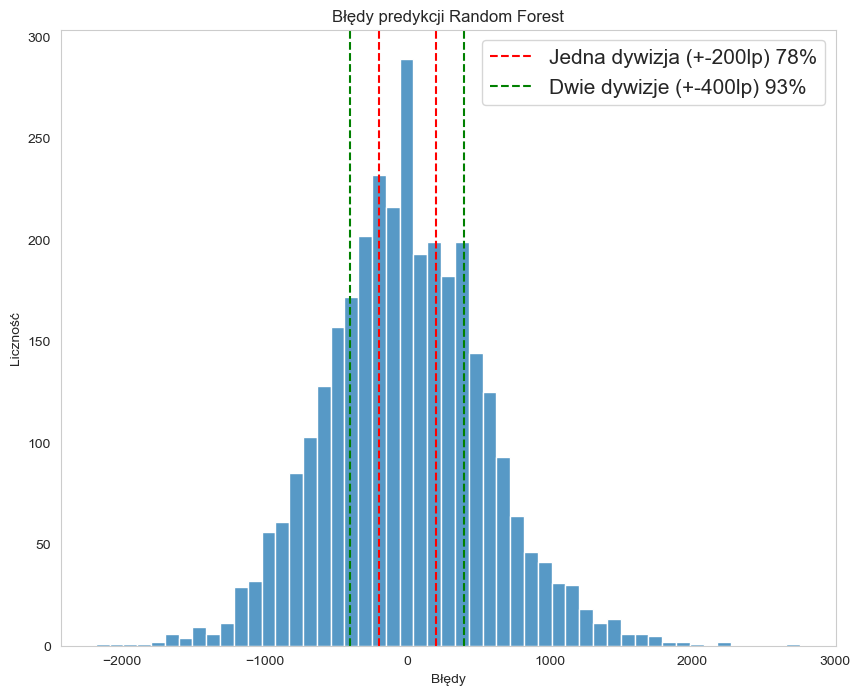

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


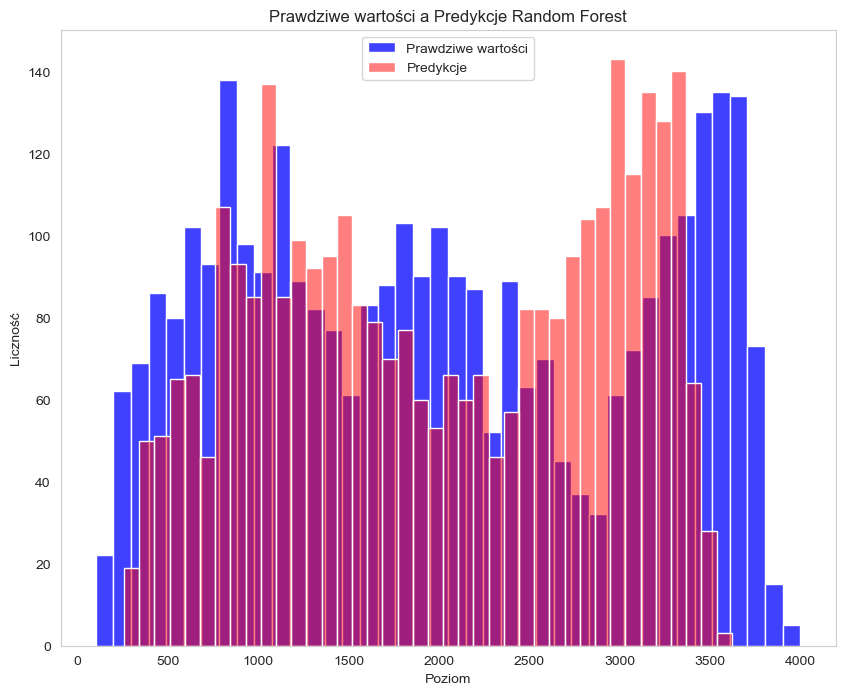

Fitting 5 folds for each of 144 candidates, totalling 720 fits
 SVR Best parameters: {'C': 100, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'rbf'} 
Support Vector Machine RMSE: 545.9601404700619


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


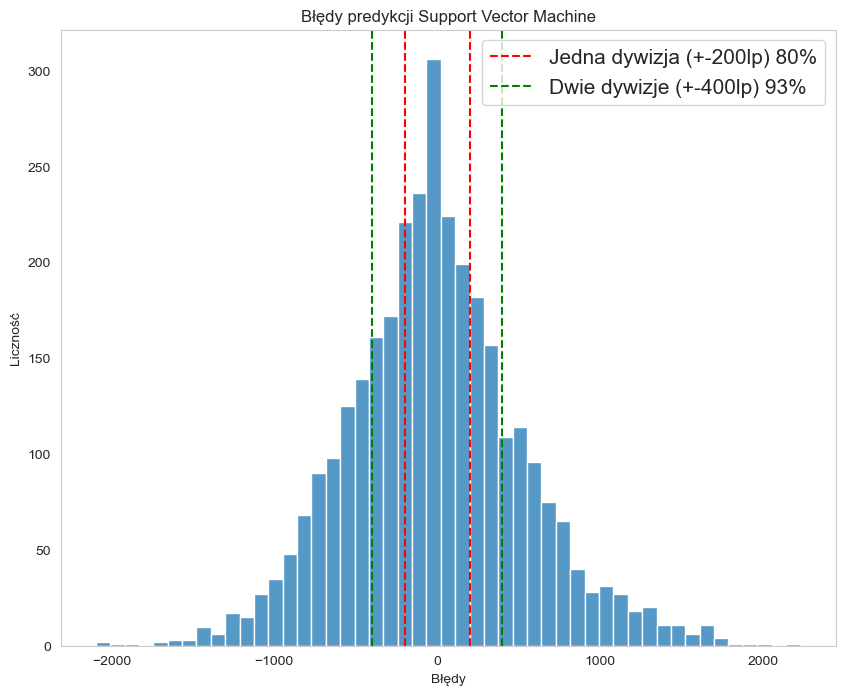

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


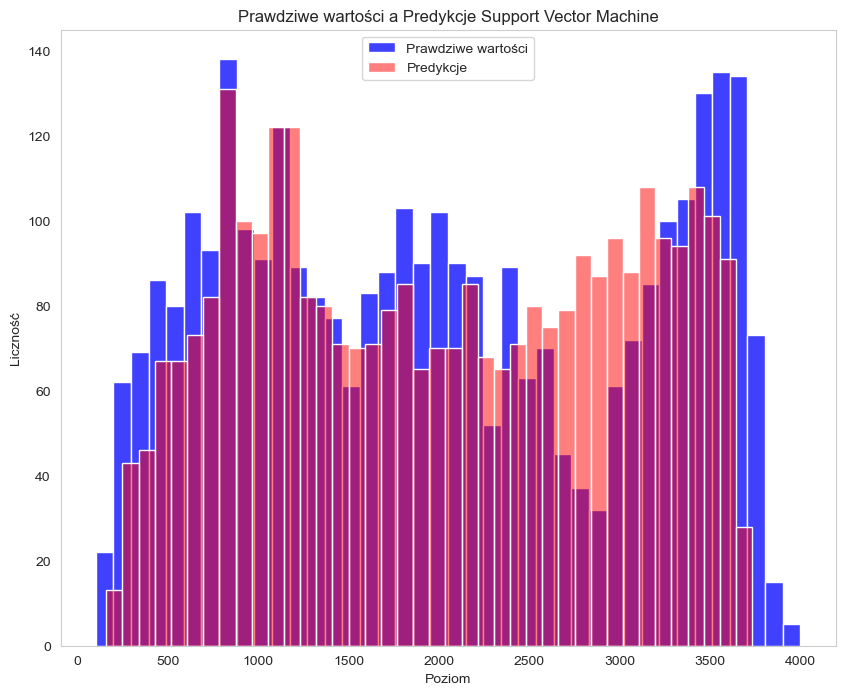

In [43]:
perform_experiment(regressors,(X_train, X_test, y_train, y_test),4)

# Experyment 5 #

Użycie PCA, 2 argumentów

In [44]:
df = Data.make_big_df(df_per_rank_list)
columns_to_drop = ['id','literal level','deaths_t']
df = df.drop(columns=columns_to_drop)
y = df['lvl']
X = df.drop(columns=['lvl'])
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)
n=2

pca = PCA(n_components=n) 
X_pca = pca.fit_transform(x_scaled)

pca_df = pd.DataFrame(X_pca, columns=[f'Principal Component {i}' for i in range(1,n+1)])

X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.33,
                                                        random_state=42)
print("\nGłówne składowe:")
print(pca_df.head())


Główne składowe:
   Principal Component 1  Principal Component 2
0              -2.897573              -2.849318
1              -0.322005              -1.069650
2              -6.159705               0.686978
3              -2.816518              -0.041592
4               0.670002              -1.187630


Linear Model Params: [283.98397 277.41878], 2021.14254
Linear Regression RMSE: 890.2783685828739


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


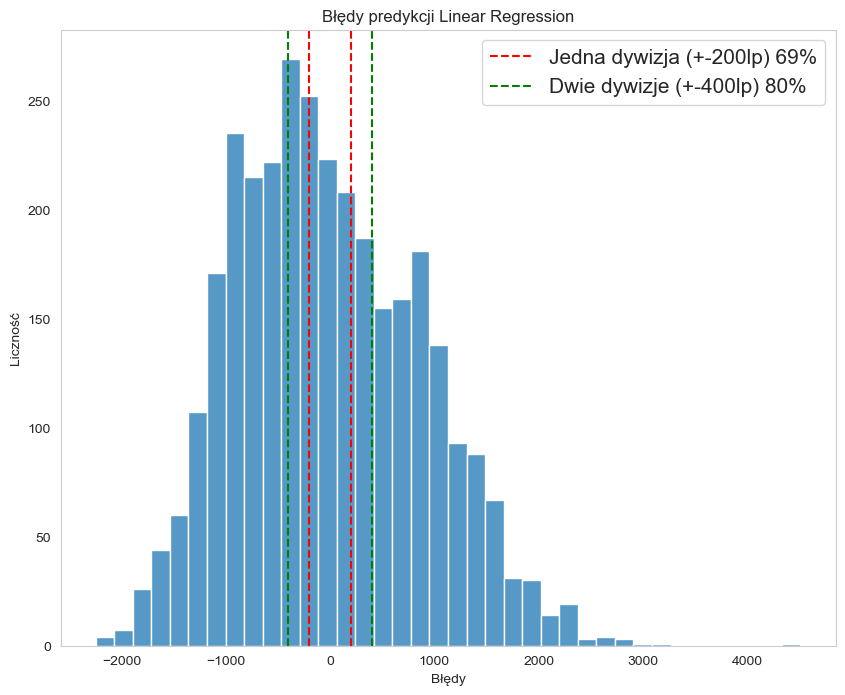

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


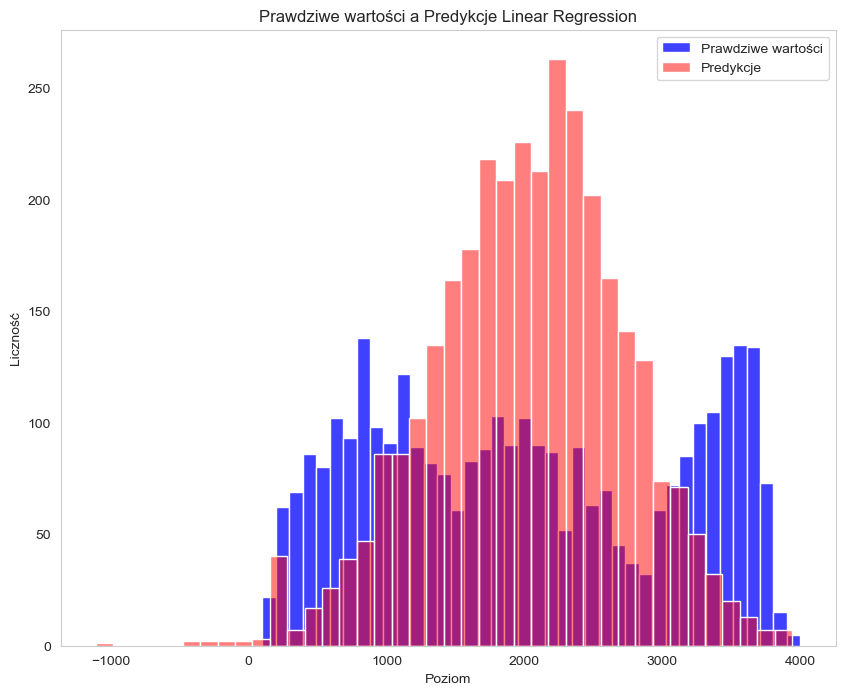

Fitting 5 folds for each of 165 candidates, totalling 825 fits
 GradientBoostingRegressor Best parameters: {'learning_rate': 0.075, 'max_depth': 5, 'n_estimators': 50} 
Gradient Boost RMSE: 865.0410826839875


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


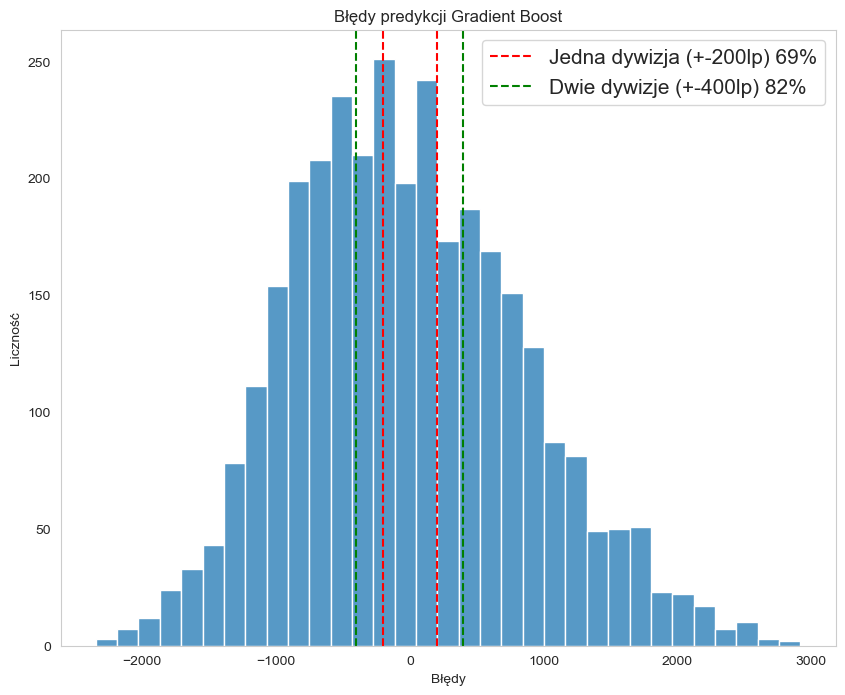

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


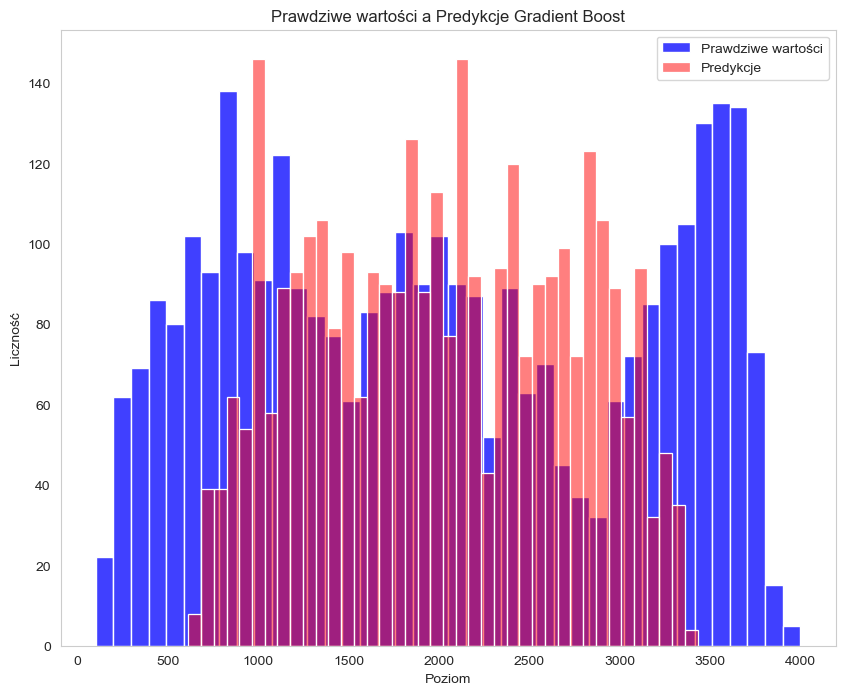

Fitting 5 folds for each of 180 candidates, totalling 900 fits
 RandomForestRegressor Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 40} 
Random Forest RMSE: 869.9434106578445


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


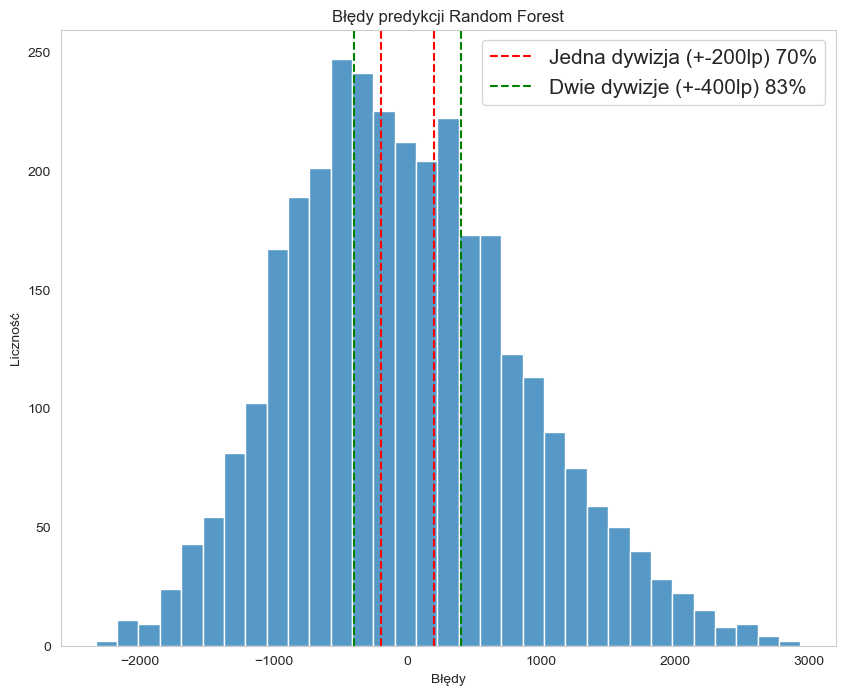

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


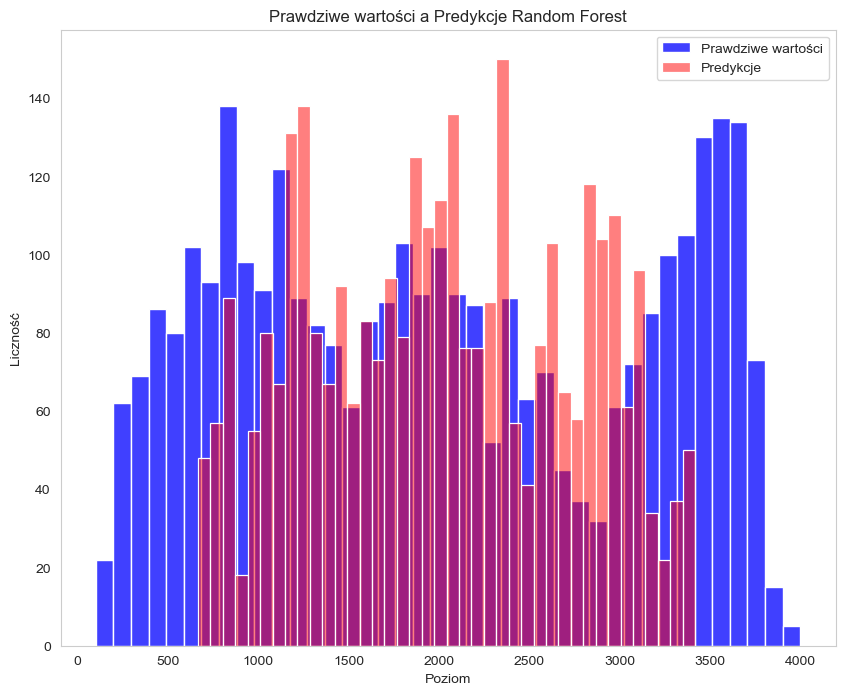

Fitting 5 folds for each of 144 candidates, totalling 720 fits
 SVR Best parameters: {'C': 90, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} 
Support Vector Machine RMSE: 876.6455146991227


C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


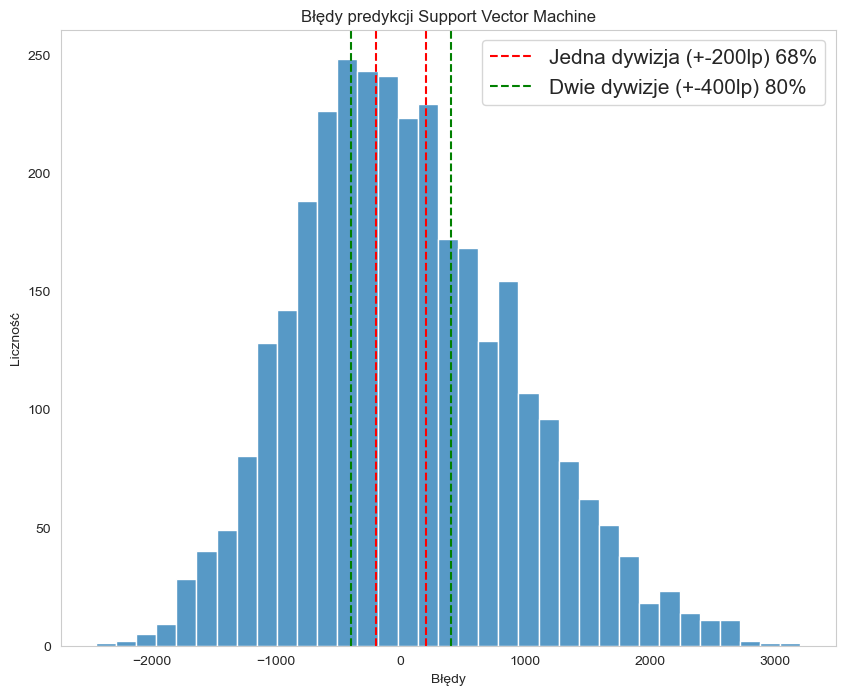

C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mikolaj\miniconda3\envs\MyEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


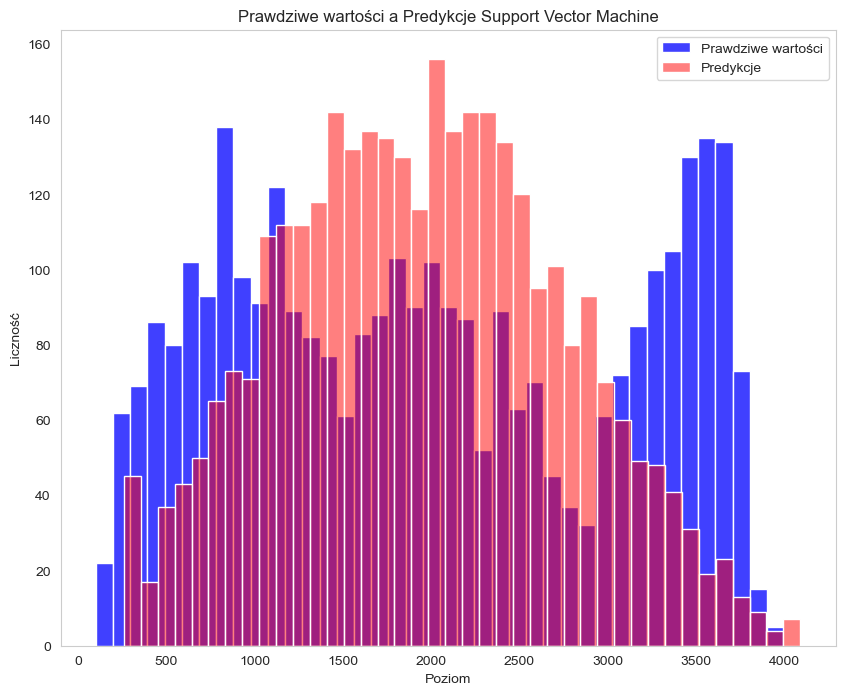

In [45]:
perform_experiment(regressors, (X_train, X_test, y_train, y_test), 5)